### Import Libraries 

In [1]:
!pip install mplfinance
!pip install tensorflow
!pip install yfinance

  Obtaining dependency information for mplfinance from https://files.pythonhosted.org/packages/d7/d9/31c436ea7673c21a5bf3fc747bc7f63377582dfe845c3004d3e46f9deee0/mplfinance-0.12.10b0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 7.3 MB/s eta 0:00:00
  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/5a/f2/5c2f878c62c8b79c629b11b33516bb55054d7677eba6f56f3a20296b56bd/tensorflow-2.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 8.1 MB/s eta 0:00:00
  Obtaining dependency information for flatbuffers>=23.1.21 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
  Obtaining dependency information for grpcio<2.0,>=1.24.3 from https://files.pythonhosted.org/packages/28/fa/c38a010d3fffcac07ef121abb34eb2c3db0876df74267ce5bde1

In [2]:
!pip install -U sagemaker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.8/867.8 kB 11.0 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for sagemaker: filename=sagemaker-2.180.0-py2.py3-none-any.whl size=1182555 sha256=5058f8efabc10d6e889d072ca091f86cfc4406a6edf037d254944cc893841f15
  Stored in directory: /home/ec2-user/.cache/pip/wheels/07/a7/07/c7db95e29daeff62705508b3d6ee55db71e34d7c369d94dfd8
Successfully built sagemaker
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.177.1
    Uninstalling sagemaker-2.177.1:
      Successfully uninstalled sagemaker-2.177.1


In [3]:
import pandas as pd
import tensorflow
import yfinance as yf
import datetime
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import boto3
import sagemaker 
import tensorflow as tf
import mplfinance as mpf
from sagemaker.tensorflow import TensorFlow
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, ContinuousParameter
import json

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

2023-08-25 03:48:16.495303: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-25 03:48:18.039631: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
train_ratio = 0.7
test_ratio = 0.2
start_date = "2013-03-25"
end_date = "2023-08-24"
symbols = ["AAPL", "AMZN", "MSFT", "GOOGL"]

### Retreive data and upload data. 

In [7]:
def download_data(symbols, start_date, end_date):
    """
    Downloads historical stock data from Yahoo Finance.

    Input:
    - symbols: List of stock symbols to download data for
    - start_date: Start date for the historical data
    - end_date: End date for the historical data
    """
    folder_path = "data/raw"  

    # Check if the folder exists, otherwise create it
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    for symbol in symbols:
        data = yf.download(symbol, start=start_date, end=end_date)
        file_path = os.path.join(folder_path, f"{symbol}_data.csv")
        data.to_csv(file_path, index=True)
        print(f"Data downloaded for symbol: {symbol}")

In [8]:
download_data(symbols, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed
Data downloaded for symbol: AAPL
[*********************100%%**********************]  1 of 1 completed
Data downloaded for symbol: AMZN
[*********************100%%**********************]  1 of 1 completed
Data downloaded for symbol: MSFT
[*********************100%%**********************]  1 of 1 completed
Data downloaded for symbol: GOOGL


In [9]:
s3_client = boto3.client('s3')
session = sagemaker.Session()

# Get default bucket
bucket_name = session.default_bucket()

# Get the role ARN
role_arn = sagemaker.get_execution_role()
region = boto3.session.Session().region_name


print("Bucket Name:", bucket_name)
print("Role ARN:", role_arn)
print("Region:", region)

Bucket Name: sagemaker-us-east-1-464589117859
Role ARN: arn:aws:iam::464589117859:role/service-role/AmazonSageMaker-ExecutionRole-20230823T181343
Region: us-east-1


In [10]:
!aws s3 cp data s3://sagemaker-us-east-1-464589117859/ --recursive

upload: data/processed/AAPL/test/dates.npy to s3://sagemaker-us-east-1-464589117859/processed/AAPL/test/dates.npy
upload: data/processed/AAPL/test/y.npy to s3://sagemaker-us-east-1-464589117859/processed/AAPL/test/y.npy
upload: data/processed/AMZN/test/y.npy to s3://sagemaker-us-east-1-464589117859/processed/AMZN/test/y.npy
upload: data/processed/AAPL/test/X.npy to s3://sagemaker-us-east-1-464589117859/processed/AAPL/test/X.npy
upload: data/processed/AAPL/train/X.npy to s3://sagemaker-us-east-1-464589117859/processed/AAPL/train/X.npy
upload: data/processed/AMZN/test/dates.npy to s3://sagemaker-us-east-1-464589117859/processed/AMZN/test/dates.npy
upload: data/processed/AMZN/train/X.npy to s3://sagemaker-us-east-1-464589117859/processed/AMZN/train/X.npy
upload: data/processed/AAPL/val/dates.npy to s3://sagemaker-us-east-1-464589117859/processed/AAPL/val/dates.npy
upload: data/processed/AAPL/val/y.npy to s3://sagemaker-us-east-1-464589117859/processed/AAPL/val/y.npy
upload: data/processed

### EDA

In [91]:
def visualize_stock_data(stock, symbol):
    """
    Visualizes the stock data for the given symbol.

    Input:
    - symbol: Stock symbol (e.g., "AAPL", "AMZN", ...)

    Output:
    - Displays line graphs, heat plot, and other visualizations
    """

    required_columns = ['High', 'Low', 'Close', 'Volume']
    for col in required_columns:
        if col not in stock_data.columns:
            print(f"Column '{col}' not found in the data.")
            return

    # Create subplots
    fig, axs = plt.subplots(3, 2, figsize=(16, 20))
    fig.suptitle(f'{symbol} Stock Data Visualizations', fontsize=16)

    # Line Graphs
    axs[0, 0].plot(stock_data.index, stock_data['High'], label='High')
    axs[0, 0].set_ylabel('Price')
    axs[0, 0].set_title('High Prices')

    sns.histplot(stock_data['Close'], bins=50, kde=True, label=symbol, ax=axs[0, 1])
    axs[0, 1].set_title("Histogram of Close Prices")
    axs[0, 1].set_xlabel("Price")
    axs[0, 1].set_ylabel("Frequency")
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    axs[1, 0].plot(stock_data.index, stock_data['Close'], label='Close')
    axs[1, 0].set_xlabel('Date')
    axs[1, 0].set_ylabel('Price')
    axs[1, 0].set_title('Close Prices')

    # Candlestick Chart
    if 'Open' in stock_data.columns and 'Volume' in stock_data.columns:
        mpf.plot(stock_data, type='candle', style='yahoo', ax=axs[1, 1], volume=axs[2, 0])
        axs[1, 1].set_title('Candlestick Chart')
    else:
        print("Columns 'Open' and/or 'Volume' missing. Skipping Candlestick chart.")

    # Moving Averages
    axs[2, 1].plot(stock_data.index, stock_data['Close'], label='Close')
    axs[2, 1].plot(stock_data.index, stock_data['Close'].rolling(window=50).mean(), label='50-day Moving Average')
    axs[2, 1].plot(stock_data.index, stock_data['Close'].rolling(window=200).mean(), label='200-day Moving Average')
    axs[2, 1].set_xlabel('Date')
    axs[2, 1].set_ylabel('Price')
    axs[2, 1].set_title('Moving Averages')
    axs[2, 1].legend()

    # Adjust spacing between subplots
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Tables
    print(f"Head of {symbol} Stock Data:\n{stock_data.head()}\n")
    print(f"Variable info of {symbol} Stock Data:\n{stock_data.info()}\n")
    print(f"Summary Statistics of {symbol} Stock Data:\n{stock_data.describe()}\n")
    print(f"Correlation Matrix of {symbol} Stock Data:\n{stock_data[['High', 'Low', 'Close']].corr()}\n")

    # Show the plots
    plt.savefig(f'Images/{symbol}_visualization.png')


In [92]:
def handle_null_values(data, stock_name):
    """
    Handles null values in the data.

    Input:
    - data: Pandas DataFrame containing the stock data

    Output:
    - data: Pandas DataFrame with null values handled
    """
    null_percentage = data.isnull().sum() / len(data) * 100
    columns_to_remove = null_percentage[null_percentage > 60].index
    columns_to_fill = null_percentage[null_percentage <= 60].index
    if not columns_to_remove.empty:
        data.drop(columns_to_remove, axis=1, inplace=True)

    if not columns_to_fill.empty:
        data[columns_to_fill] = data[columns_to_fill].fillna(data[columns_to_fill].mean())

    if data.isnull().any().any():
        print(f"There are still null values present in the data after handling {stock_name}.")
    else:
        print(f"No null values present in the data after handling {stock_name}.")
  
    return data

No null values present in the data after handling AAPL.
Head of AAPL Stock Data:
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2013-03-25  16.596071  16.783930  16.492144  16.556429  14.260466  501135600
2013-03-26  16.622856  16.637142  16.447500  16.469286  14.185412  294294000
2013-03-27  16.302143  16.314285  16.097500  16.145714  13.906707  331237200
2013-03-28  16.065001  16.136429  15.772143  15.809286  13.616934  442839600
2013-04-01  15.782143  15.846429  15.276429  15.318214  13.193966  389732000

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2623 entries, 2013-03-25 to 2023-08-23
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2623 non-null   float64
 1   High       2623 non-null   float64
 2   Low        2623 non-null   float64
 3   Close      2623 non-null   float64
 4   Adj Close 

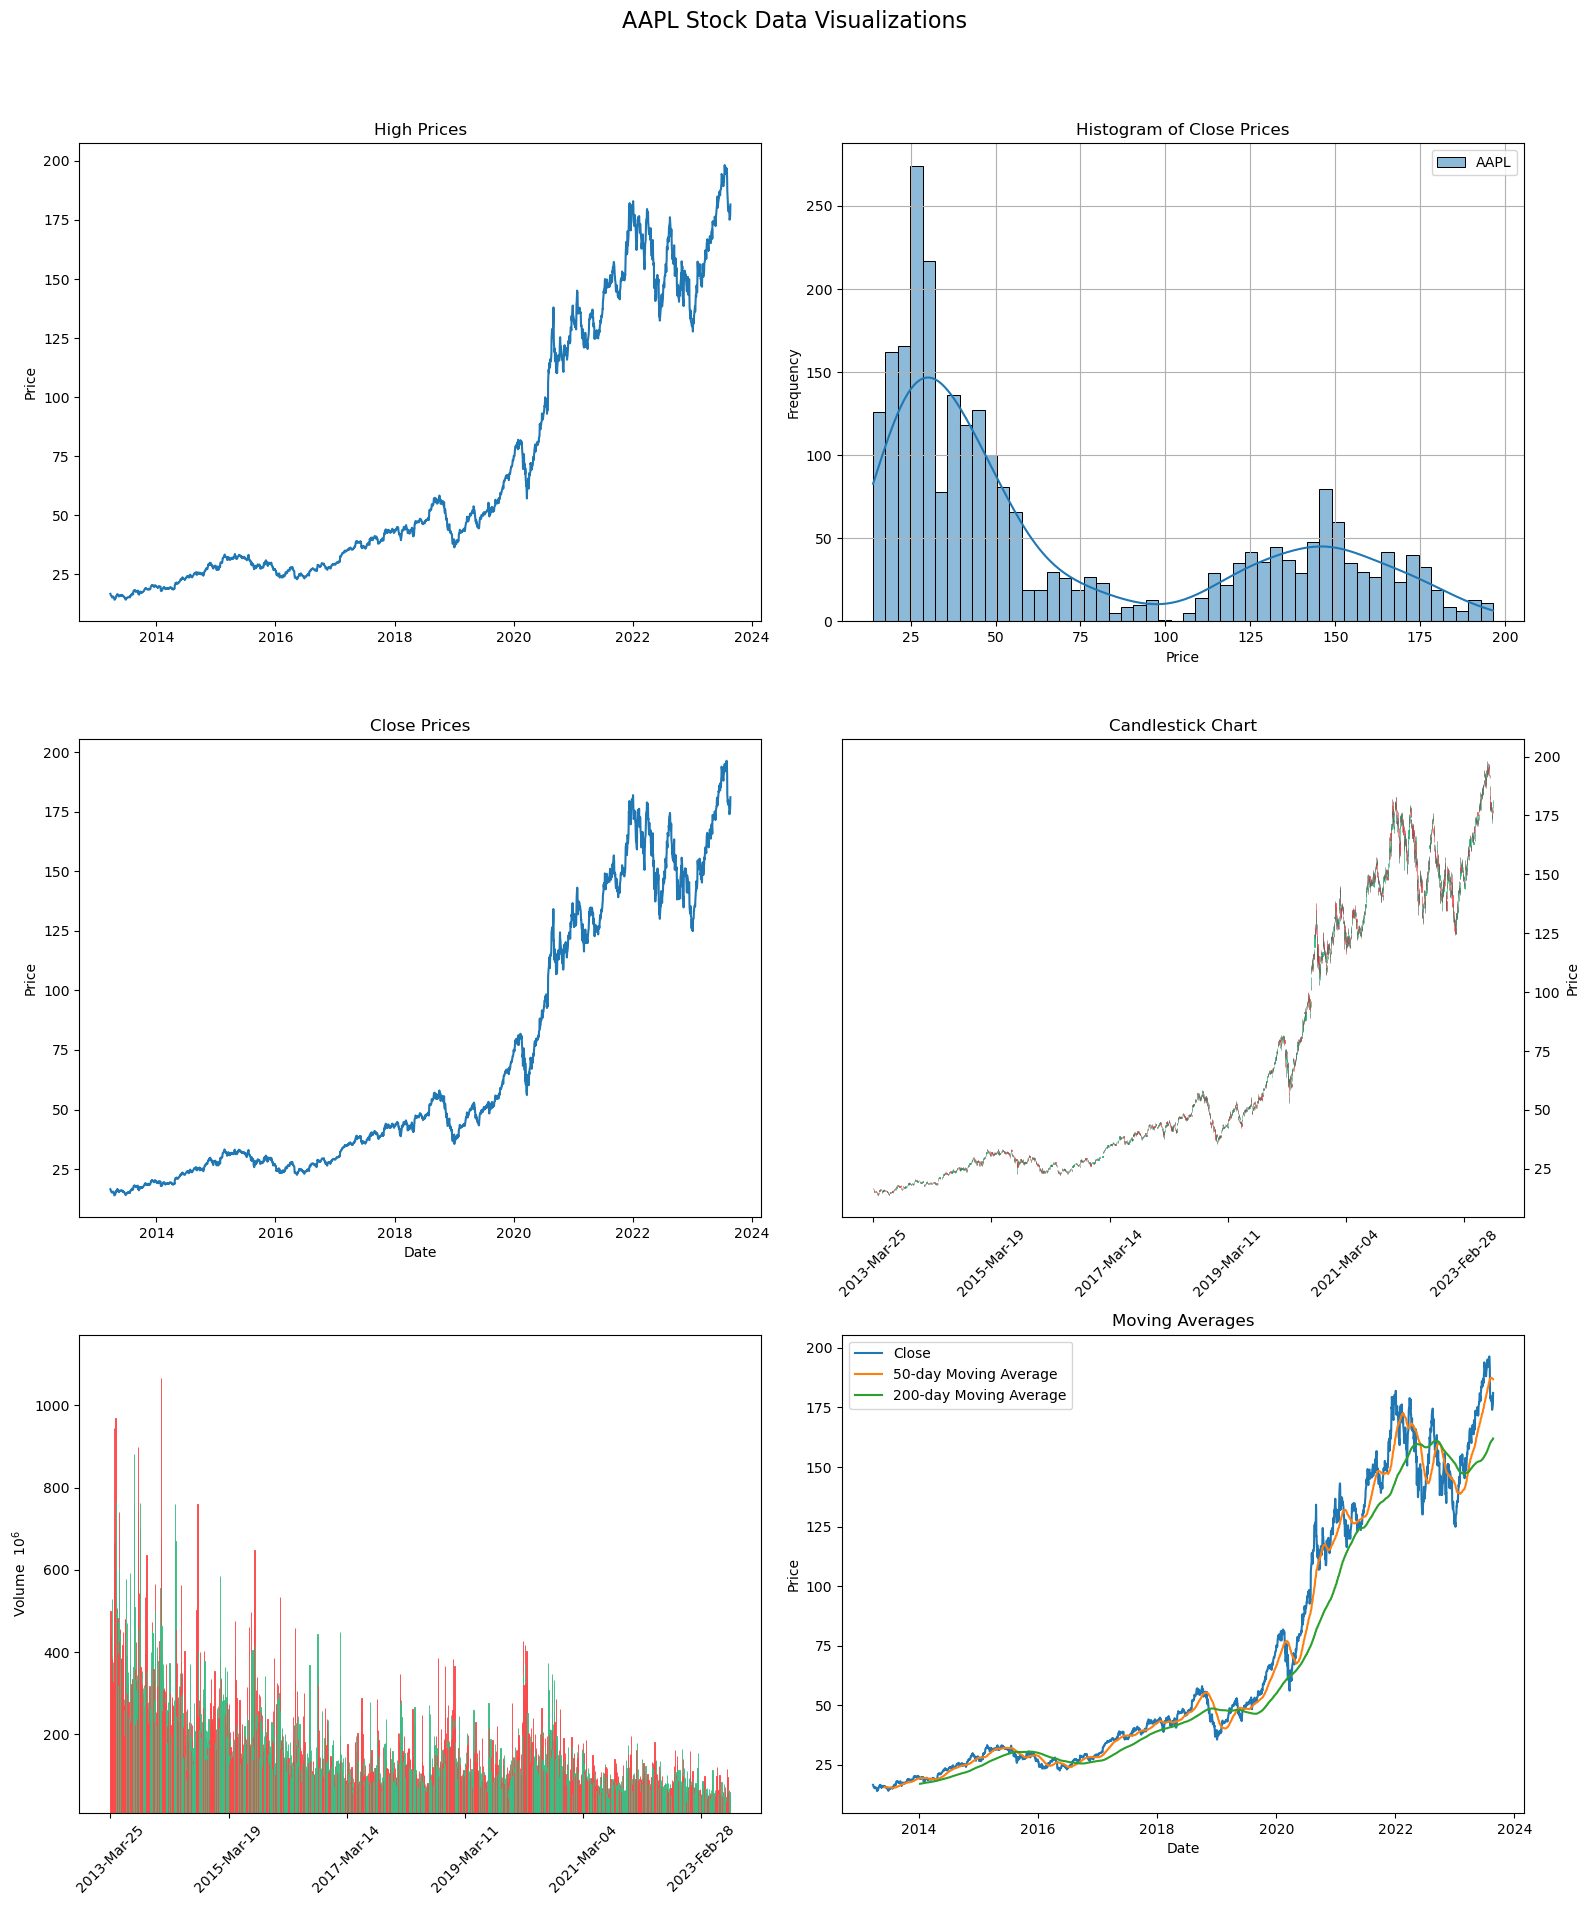

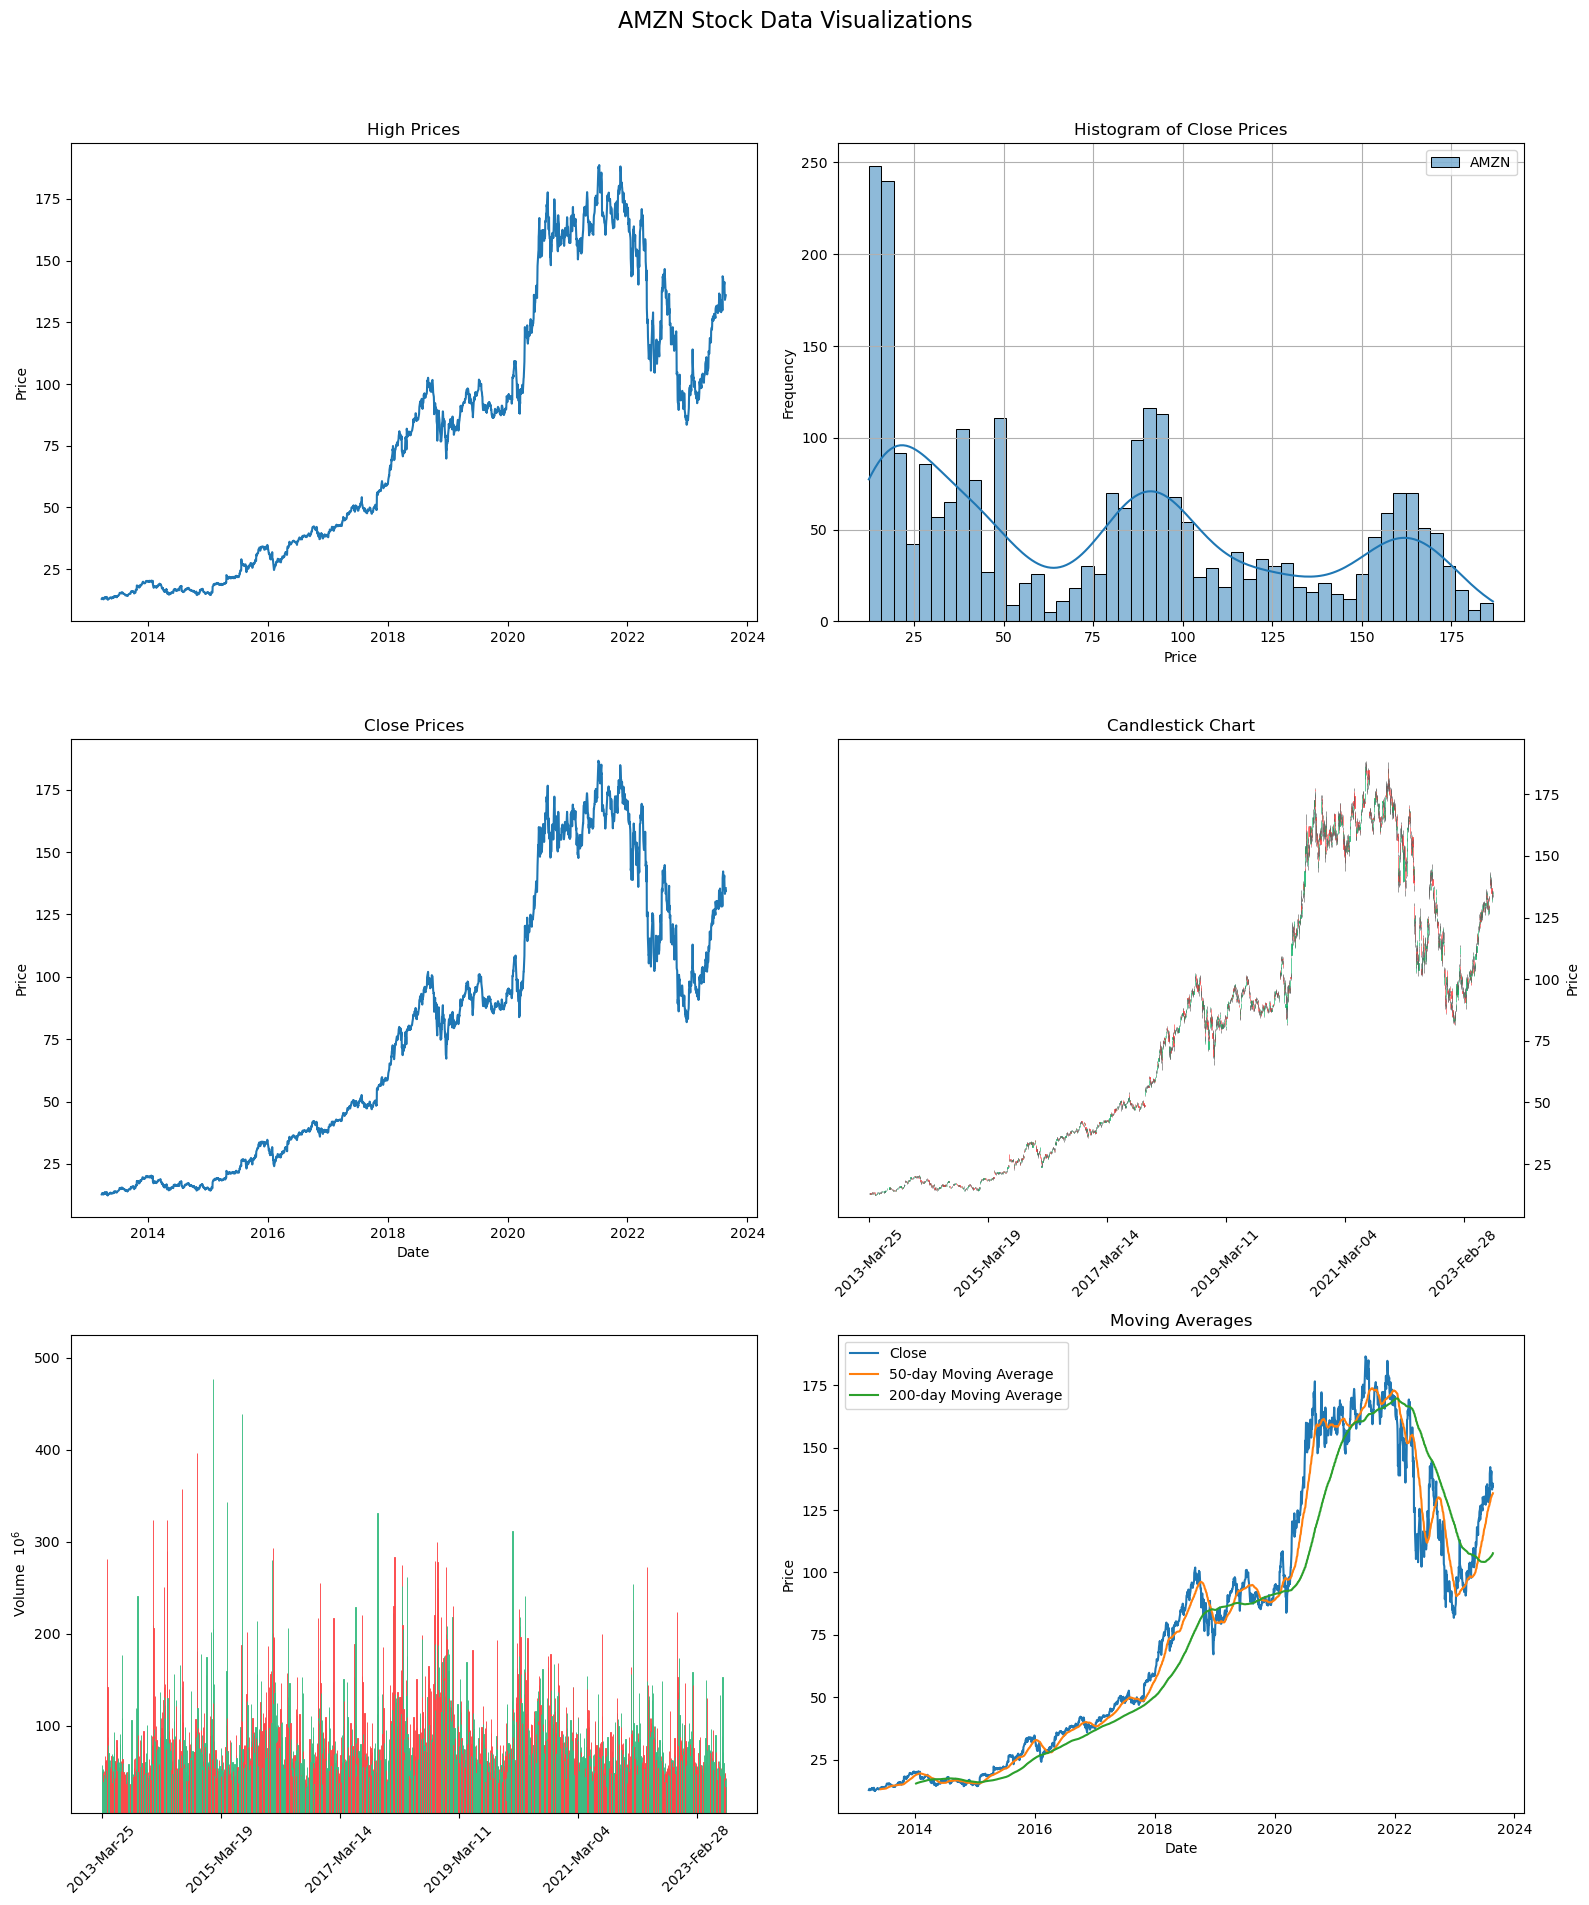

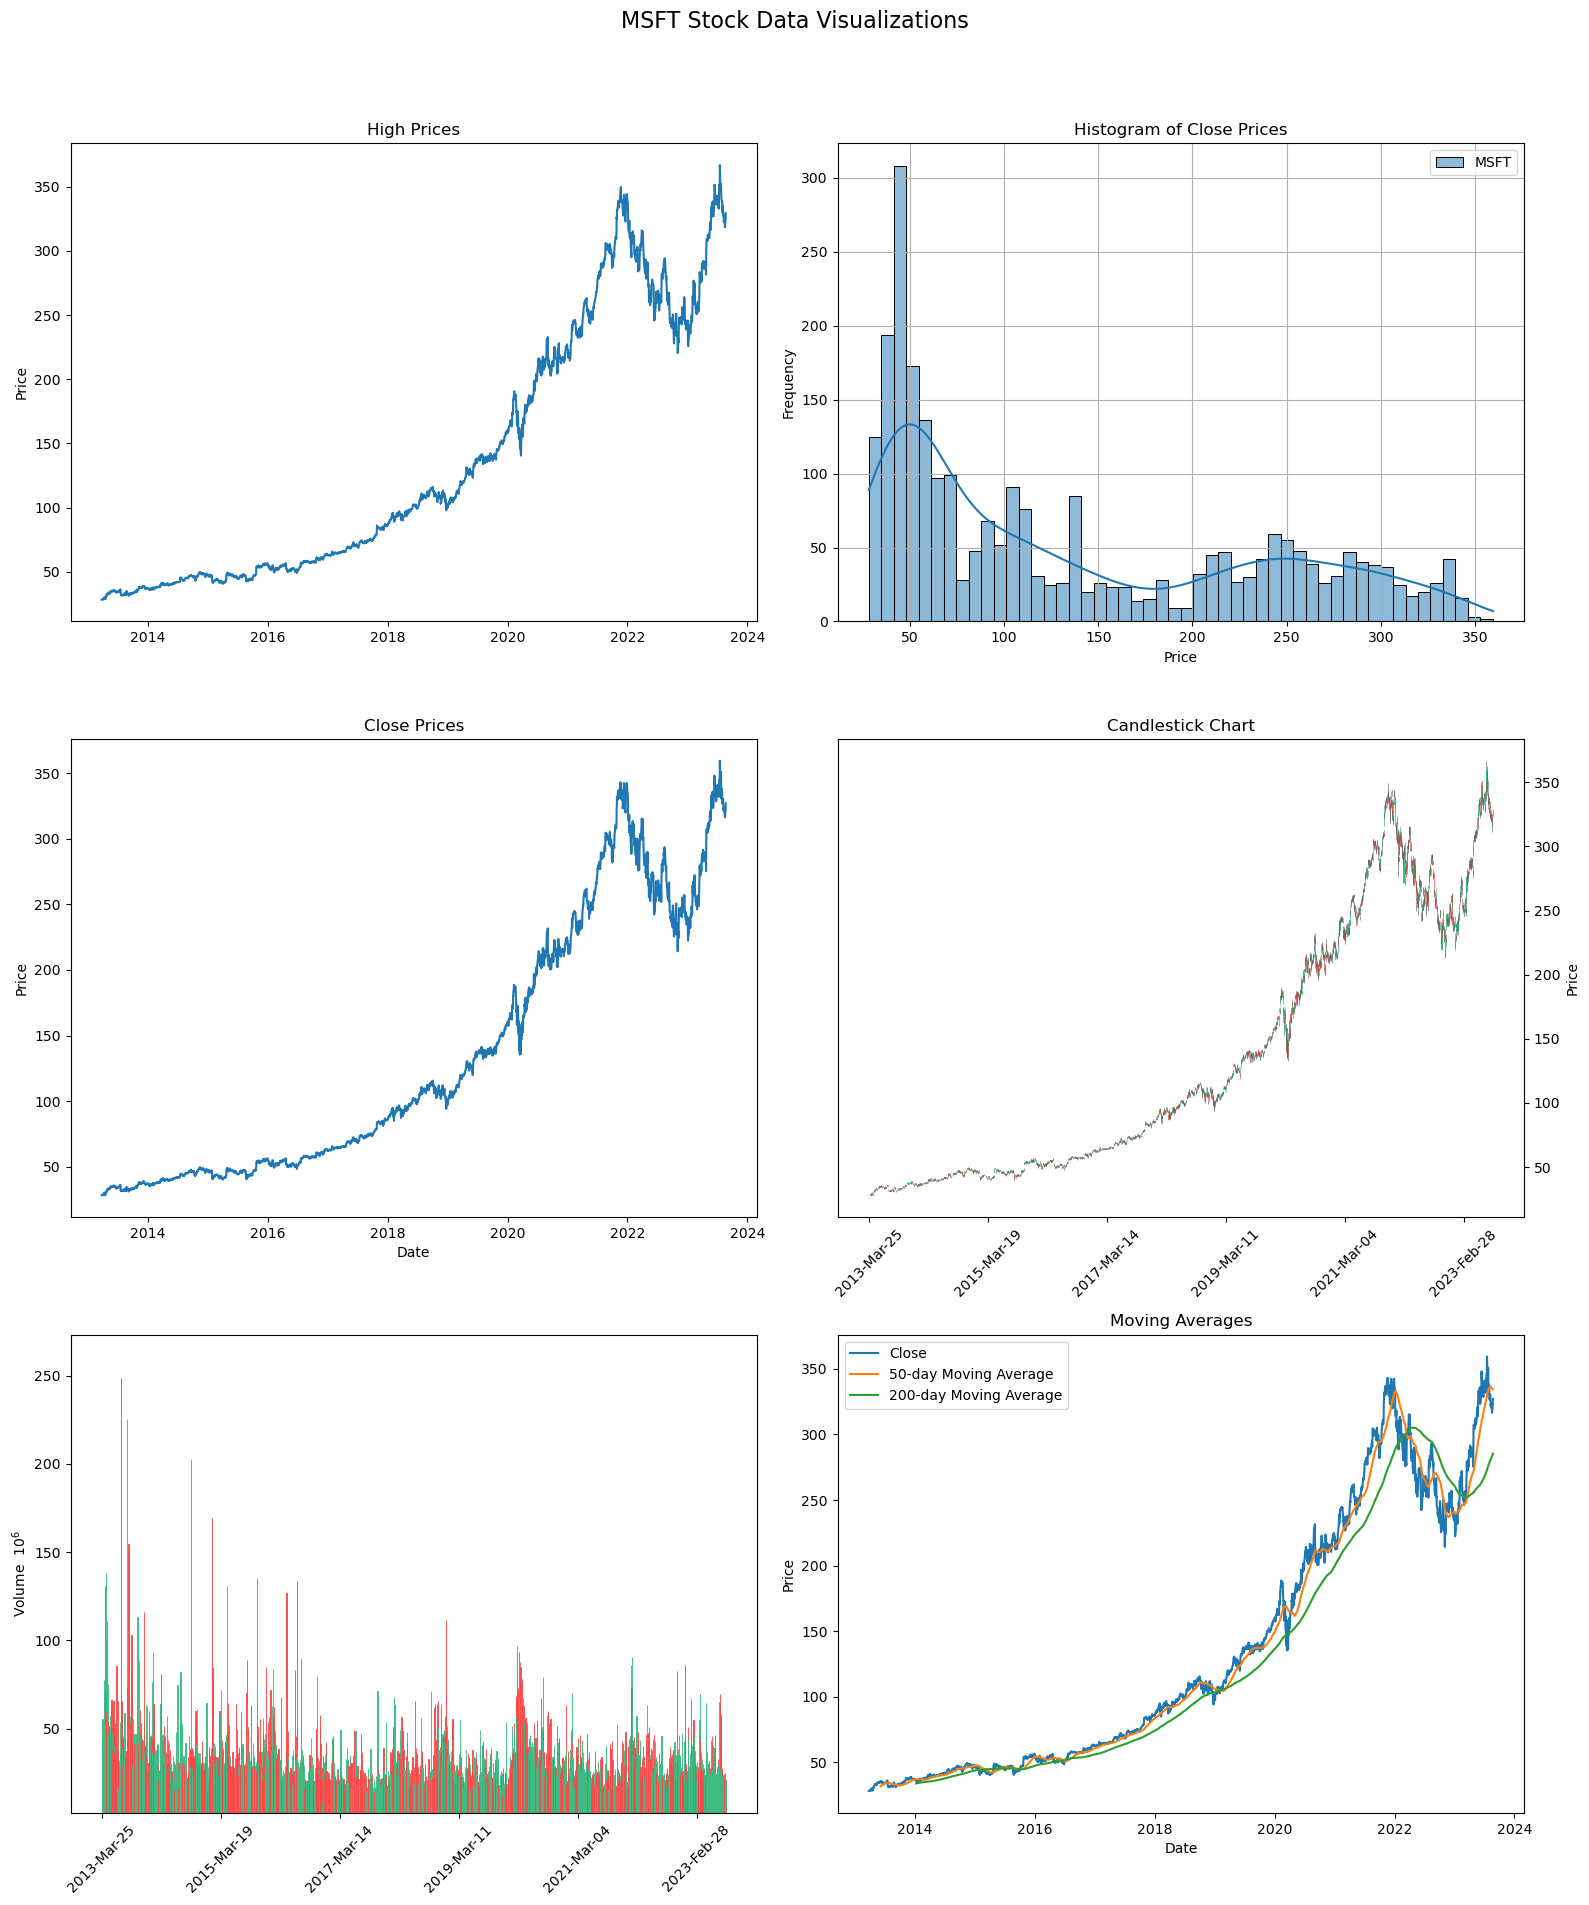

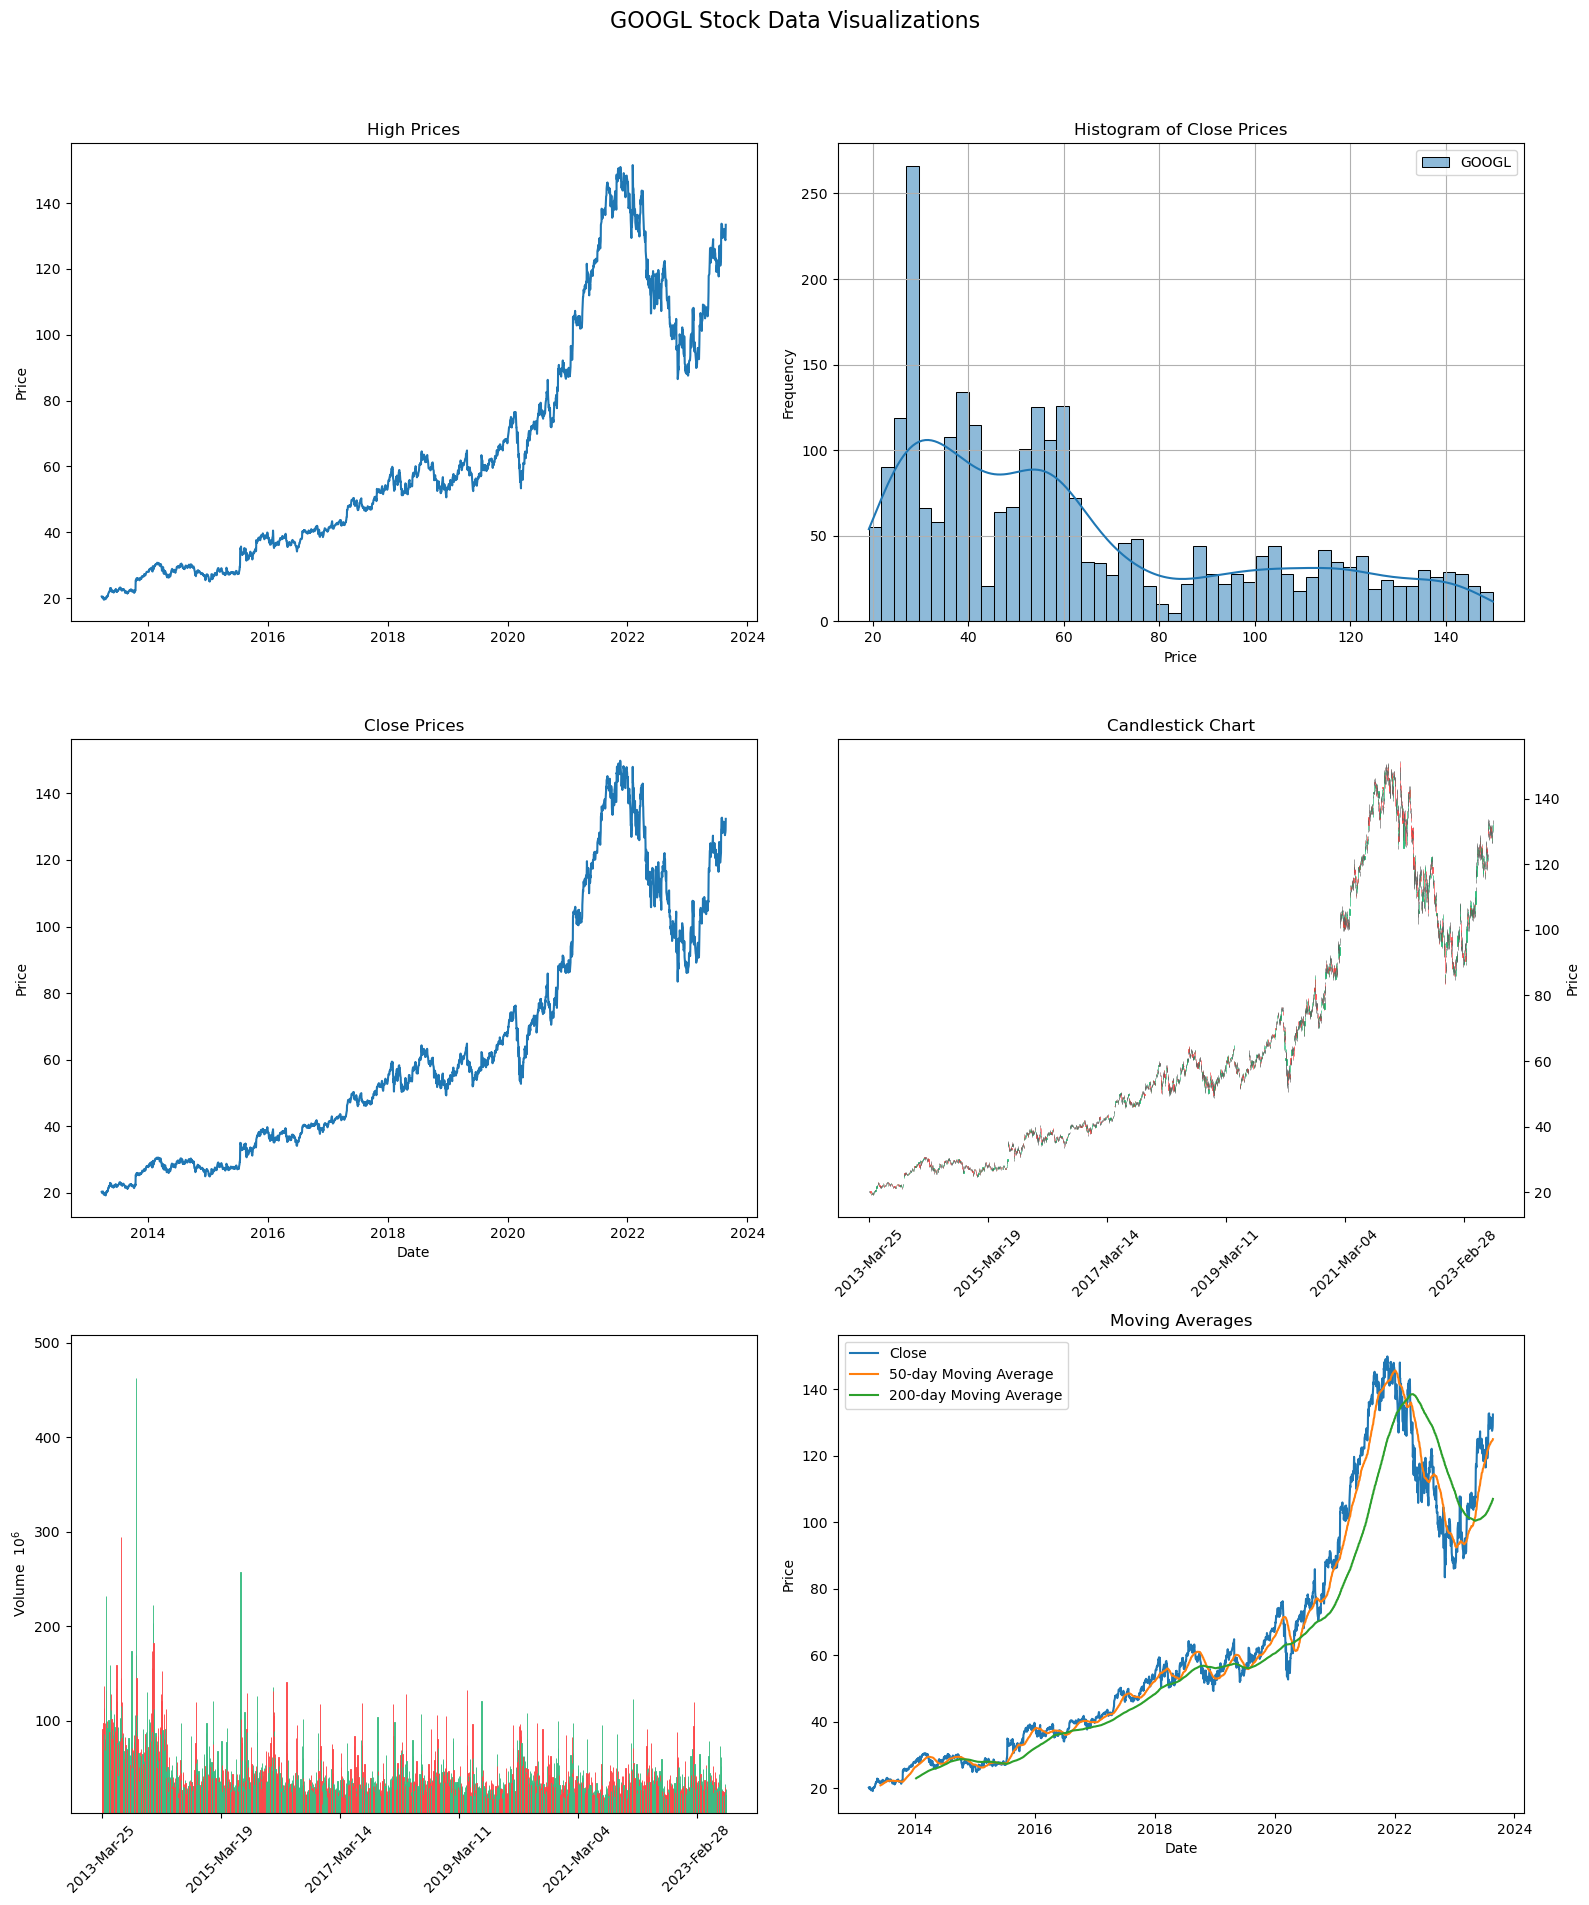

In [93]:
path = "data/raw/"
stocks = {}
for symbol in symbols:
    file_path = os.path.join(path, f"{symbol}_data.csv")
    
    try:
        stock_data = pd.read_csv(file_path)
        stock_data['Date'] = pd.to_datetime(stock_data['Date'])
        stock_data.set_index('Date', inplace=True)
    except FileNotFoundError:
        print(f"File {file_path} not found.")
        continue

    # Handle null values and visualze the data 
    cleaned_data = handle_null_values(stock_data, symbol)
    visualize_stock_data(cleaned_data, symbol)
    
    stocks[symbol] = stock_data['Adj Close']

In [94]:
stocks.keys()

dict_keys(['AAPL', 'AMZN', 'MSFT', 'GOOGL'])

In [96]:
stocks['AAPL'].head()

Date
2013-03-25    14.260466
2013-03-26    14.185412
2013-03-27    13.906707
2013-03-28    13.616934
2013-04-01    13.193966
Name: Adj Close, dtype: float64

In [103]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = datetime.datetime.strptime(first_date_str, '%Y-%m-%d')
  last_date = datetime.datetime.strptime(last_date_str, '%Y-%m-%d')

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset.to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,121.589798,120.752205,118.337936,118.830627
1,2021-03-26,120.752205,118.337936,118.830627,119.441597
2,2021-03-29,118.337936,118.830627,119.441597,119.618973
3,2021-03-30,118.830627,119.441597,119.618973,118.150711
4,2021-03-31,119.441597,119.618973,118.150711,120.367882
5,2021-04-01,119.618973,118.150711,120.367882,121.205475
6,2021-04-05,118.150711,120.367882,121.205475,124.063179
7,2021-04-06,120.367882,121.205475,124.063179,124.368652
8,2021-04-07,121.205475,124.063179,124.368652,126.033981
9,2021-04-08,124.063179,124.368652,126.033981,128.458115


In [110]:
windowed_df_AAPL = df_to_windowed_df(stocks['AAPL'], '2018-03-23', '2023-08-23', n=3)
windowed_df_AMZN = df_to_windowed_df(stocks['AMZN'], '2018-03-23', '2023-08-23', n=3)
windowed_df_MSFT = df_to_windowed_df(stocks['MSFT'], '2018-03-23', '2023-08-23', n=3)
windowed_df_GOOGL = df_to_windowed_df(stocks['GOOGL'], '2018-03-23', '2023-08-23', n=3)

In [117]:
windowed_df = [windowed_df_AAPL, windowed_df_AMZN, windowed_df_MSFT, windowed_df_GOOGL]

In [111]:
windowed_df_GOOGL.head()

,Target Date,Target-3,Target-2,Target-1,Target
0,2018-03-23,54.790001,54.700001,52.657501,51.327499
1,2018-03-26,54.700001,52.657501,51.327499,52.704498
2,2018-03-27,52.657501,51.327499,52.704498,50.347000
3,2018-03-28,51.327499,52.704498,50.347000,50.258999
4,2018-03-29,52.704498,50.347000,50.258999,51.856998


In [112]:
windowed_df_GOOGL.tail()

,Target Date,Target-3,Target-2,Target-1,Target
1359,2023-08-17,131.330002,129.779999,128.699997,129.919998
1360,2023-08-18,129.779999,128.699997,129.919998,127.459999
1361,2023-08-21,128.699997,129.919998,127.459999,128.369995
1362,2023-08-22,129.919998,127.459999,128.369995,129.080002
1363,2023-08-23,127.459999,128.369995,129.080002,132.369995


In [114]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df_AAPL)

dates.shape, X.shape, y.shape

((1364,), (1364, 3, 1), (1364,))

(array([17167., 17532., 17897., 18262., 18628., 18993., 19358.]),
 [Text(17167.0, 0, '2017'),
  Text(17532.0, 0, '2018'),
  Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021'),
  Text(18993.0, 0, '2022'),
  Text(19358.0, 0, '2023')])

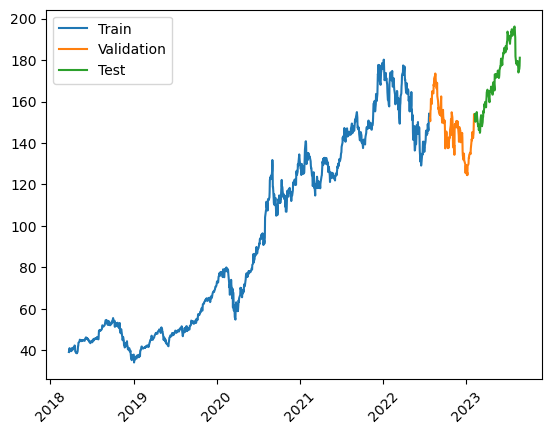

In [115]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])
plt.xticks(rotation=45)


In [116]:
def process_stock(windowed_df):
    dates, X, y = windowed_df_to_date_X_y(windowed_df)
    
    q_80, q_90 = int(len(dates) * .8), int(len(dates) * .9)
    
    dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
    dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
    dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]
    
    return (dates_train, X_train, y_train), (dates_val, X_val, y_val), (dates_test, X_test, y_test)

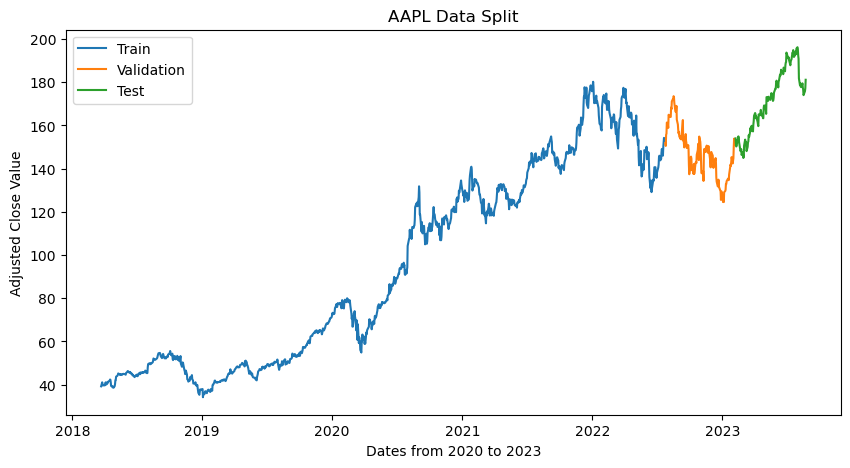

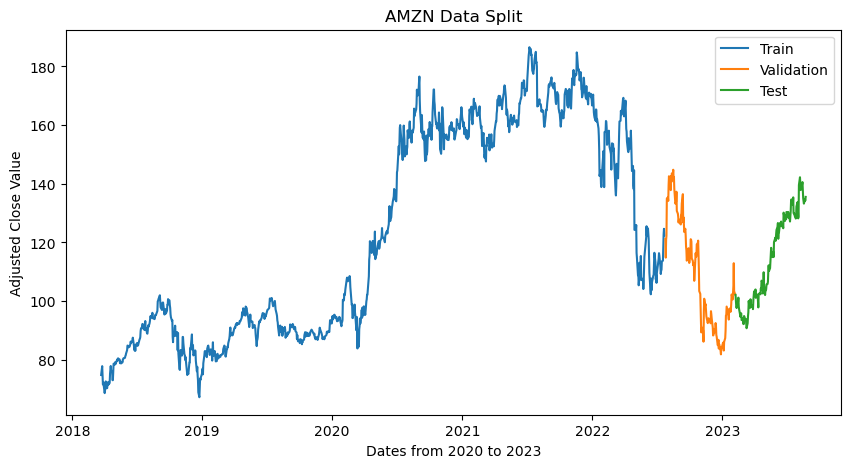

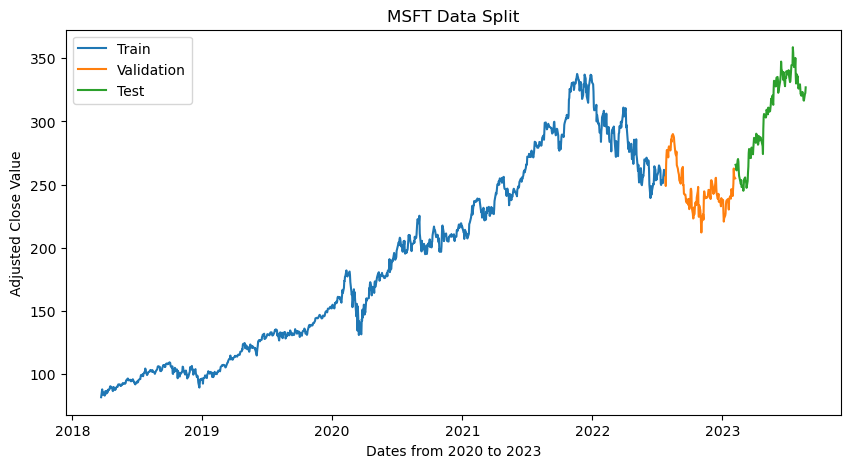

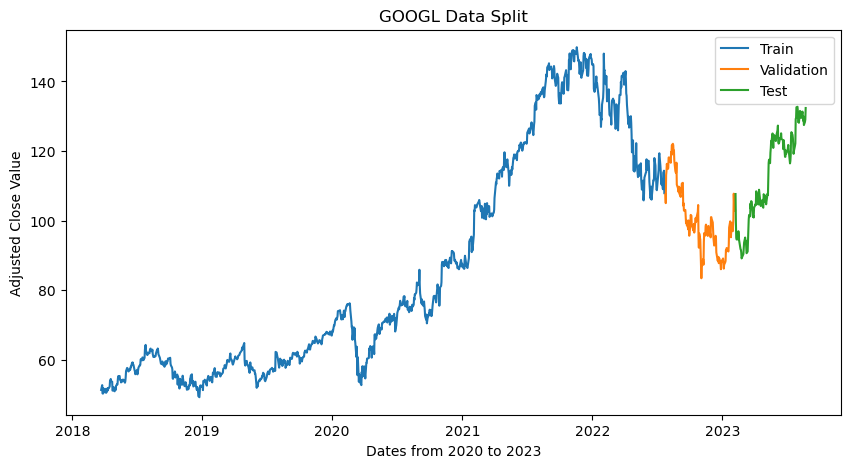

In [122]:
def save_data_to_folder(stock_name, split_name, dates, X, y):
    """Save the processed data to a specific folder."""
    base_path = os.path.join("data", "processed", stock_name, split_name)
    
    # Ensure directory exists
    if not os.path.exists(base_path):
        os.makedirs(base_path)
    
    # Save dates, X, and y to the folder
    np.save(os.path.join(base_path, "dates.npy"), dates)
    np.save(os.path.join(base_path, "X.npy"), X)
    np.save(os.path.join(base_path, "y.npy"), y)

data_collection = {}
for idx, df in enumerate(windowed_df):
    (dates_train, X_train, y_train), (dates_val, X_val, y_val), (dates_test, X_test, y_test) = process_stock(df)
    
    data_collection[symbols[idx]] = {
        'X_train': X_train,
        'y_train': y_train,
        'X_val': X_val,
        'y_val': y_val,
        'X_test': X_test,
        'y_test': y_test,
        'dates_train': dates_train,
        'dates_val': dates_val,
        'dates_test': dates_test
    }
    
    #Save the processed data to local folders
    save_data_to_folder(symbols[idx], "train", dates_train, X_train, y_train)
    save_data_to_folder(symbols[idx], "val", dates_val, X_val, y_val)
    save_data_to_folder(symbols[idx], "test", dates_test, X_test, y_test)
    
    #Plotting (kept as before)
    plt.figure(figsize=(10, 5))
    plt.title(f'{symbols[idx]} Data Split')
    plt.plot(dates_train, y_train)
    plt.plot(dates_val, y_val)
    plt.plot(dates_test, y_test)
    plt.xlabel("Dates from 2020 to 2023")
    plt.ylabel("Adjusted Close Value")
    plt.legend(['Train', 'Validation', 'Test'])
    plt.show()

In [48]:
!aws s3 cp data/processed s3://sagemaker-us-east-1-464589117859/processed --recursive

upload: data/processed/AAPL/test/X.npy to s3://sagemaker-us-east-1-464589117859/processed/AAPL/test/X.npy
upload: data/processed/AAPL/test/dates.npy to s3://sagemaker-us-east-1-464589117859/processed/AAPL/test/dates.npy
upload: data/processed/AAPL/train/X.npy to s3://sagemaker-us-east-1-464589117859/processed/AAPL/train/X.npy
upload: data/processed/AAPL/test/y.npy to s3://sagemaker-us-east-1-464589117859/processed/AAPL/test/y.npy
upload: data/processed/AMZN/val/dates.npy to s3://sagemaker-us-east-1-464589117859/processed/AMZN/val/dates.npy
upload: data/processed/AMZN/test/y.npy to s3://sagemaker-us-east-1-464589117859/processed/AMZN/test/y.npy
upload: data/processed/AMZN/train/dates.npy to s3://sagemaker-us-east-1-464589117859/processed/AMZN/train/dates.npy
upload: data/processed/AMZN/val/y.npy to s3://sagemaker-us-east-1-464589117859/processed/AMZN/val/y.npy
upload: data/processed/AAPL/train/dates.npy to s3://sagemaker-us-east-1-464589117859/processed/AAPL/train/dates.npy
upload: data

### Baseline LSTM Model

In [49]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', optimizer=Adam(learning_rate=0.001),metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50)

2023-08-25 04:01:42.723589: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/50
8/8 [==============================] - 3s 101ms/step - loss: 8175.4155 - mean_absolute_error: 84.6564 - val_loss: 9943.8682 - val_mean_absolute_error: 99.2580
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 8035.7285 - mean_absolute_error: 83.8400 - val_loss: 9782.4746 - val_mean_absolute_error: 98.4417
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 7888.1533 - mean_absolute_error: 82.9486 - val_loss: 9585.2861 - val_mean_absolute_error: 97.4346
Epoch 4/50
8/8 [==============================] - 0s 11ms/step - loss: 7698.6743 - mean_absolute_error: 81.7709 - val_loss: 9331.6699 - val_mean_absolute_error: 96.1221
Epoch 5/50
8/8 [==============================] - 0s 21ms/step - loss: 7441.4048 - mean_absolute_error: 80.1208 - val_loss: 8977.1348 - val_mean_absolute_error: 94.2528
Epoch 6/50
8/8 [==============================] - 0s 14ms/step - loss: 7073.5586 - mean_absolute_error: 77.6362 - val_loss: 8407.6230 - val_mean_absolute_

8/8 [==============================] - 1s 4ms/step


Text(0.5, 0, 'Dates 2020 - 2023')

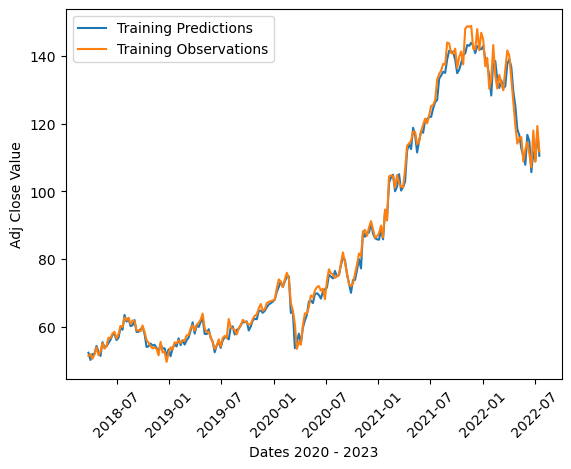

In [50]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])
plt.xticks(rotation=45)
plt.ylabel("Adj Close Value")
plt.xlabel("Dates 2020 - 2023")

### Hyperparameter tuning

In [53]:
hyperparameter_ranges = {
    'learning-rate': ContinuousParameter(0.0001, 0.1),
    'lstm_units': IntegerParameter(32, 128),
    'dense_units': IntegerParameter(16, 64)
}
objective_metric_name = 'validation:mean_absolute_error'
metric_definition =[{'Name': objective_metric_name, 'Regex': 'Validation MAE: ([0-9.]+)'}]


In [57]:
estimator = TensorFlow(entry_point='train.py',
                    role=role_arn,
                    instance_count=1,
                    instance_type='ml.m5.large',
                    framework_version='2.3.0',  # or whatever version you prefer
                    py_version='py37',
                    sagemaker_session=session)

hyperparameter_tuner = HyperparameterTuner(estimator=estimator,
                                           objective_metric_name=objective_metric_name,
                                           hyperparameter_ranges=hyperparameter_ranges,
                                           max_jobs = 2,
                                           metric_definitions = metric_definition,
                                           max_parallel_jobs=2)


NOTEBOOK_METADATA_FILE detected but failed to get valid domain and user from it.


In [58]:
def hypo_obj(stock_name):
    custom_tuner_name = f'hypo-{stock_name}'  # Customize the name here
    
    os.environ['SM_CHANNEL_TRAIN'] = f's3://{bucket_name}/processed/{stock_name}/train/'
    os.environ['SM_CHANNEL_VALID'] = f's3://{bucket_name}/processed/{stock_name}/val/'
    os.environ['SM_CHANNEL_TEST'] = f's3://{bucket_name}/processed/{stock_name}/test/'
    
    data_channels = {
        'train': f's3://{bucket_name}/processed/{stock_name}/train/',
        'valid': f's3://{bucket_name}/processed/{stock_name}/val/',
        'test': f's3://{bucket_name}/processed/{stock_name}/test/'
    }
    
    hyperparameter_tuner = HyperparameterTuner(estimator=estimator,
                                               objective_metric_name=objective_metric_name,
                                               hyperparameter_ranges=hyperparameter_ranges,
                                               max_jobs=2,
                                               metric_definitions=metric_definition,
                                               max_parallel_jobs=2,
                                               base_tuning_job_name=custom_tuner_name)  # Set the custom name
    
    hyperparameter_tuner.fit(inputs = data_channels)
    
    return hyperparameter_tuner

In [59]:
for item in symbols:
    hypo_obj(item)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Using provided s3_resource
......................................!

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config



Using provided s3_resource
....................................................!
Using provided s3_resource


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


......................................!
Using provided s3_resource


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.....................................!


In [60]:
job_names = ["hypo-AAPL-230825-0410",'hypo-AMZN-230825-0414', 
             "hypo-MSFT-230825-0418", "hypo-GOOGL-230825-0421"] #entered the names manually after finishing hpo for each of the stocks

def retrieve_hpo(job_name):
    # Initialize the SageMaker session
    sagemaker_session = sagemaker.Session()
        
    # Replace with the actual name of your Hyperparameter Tuning job
    tuning_job_name = job_name

    # Describe the Hyperparameter Tuning job
    sagemaker_client = boto3.client('sagemaker')
    tuning_job_description = sagemaker_client.describe_hyper_parameter_tuning_job(
        HyperParameterTuningJobName=tuning_job_name
    )

    # Extract best hyperparameters
    best_hyperparameters = tuning_job_description['BestTrainingJob']['TunedHyperParameters']

    # Extract best training job name
    best_training_job_name = tuning_job_description['BestTrainingJob']['TrainingJobName']
    

    return best_hyperparameters, best_training_job_name

In [61]:
aapl_hpo,_ = retrieve_hpo(job_names[0])
amzn_hpo,_ = retrieve_hpo(job_names[1])
msft_hpo,_ = retrieve_hpo(job_names[2])
googl_hpo,_ = retrieve_hpo(job_names[3])

In [62]:
hpo_dict = {
    'AAPL': aapl_hpo,
    'AMZN': amzn_hpo,
    'MSFT': msft_hpo,
    'GOOGL': googl_hpo
}

# Save the combined dictionaries to a single JSON file
directory = 'data/results/hpo'
if not os.path.exists(directory):
    os.makedirs(directory)

# Save JSON to the specified directory
output_file = os.path.join(directory, 'combined_dicts.json')
with open(output_file, 'w') as f:
    json.dump(hpo_dict, f, indent=4)

### Tuned LSTM Model for all tickers

In [129]:
def final_lstm_model(hypo, stock_name, X_train, y_train, X_val,
                     y_val, X_test, dates_test, y_test):
    # Extracting hyperparameters
    """
    Takes in the input of hyperparameters, stock_name, X_train, y_train, X_val, y_val, X_test, dates_test, y_test to give the final 
    LSTM model for each ticker, returns the model, and also saves the test predictions vs actual data
    
    """
    dense_units = int(hypo['dense_units'])
    learning_rate = float(hypo['learning-rate'])
    lstm_units = int(hypo['lstm_units'])

    # Building the model using the hyperparameters
    model = Sequential([
        layers.Input((3, 1)),
        layers.LSTM(lstm_units),
        layers.Dense(dense_units, activation='relu'),
        layers.Dense(dense_units, activation='relu'),
        layers.Dense(1)
    ])

    # Compiling the model using the learning rate from the hyperparameters
    model.compile(
        loss='mse', 
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['mean_absolute_error']
    )
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200)
    train_predictions = model.predict(X_train).flatten()
    val_predictions = model.predict(X_val).flatten()
    test_predictions = model.predict(X_test).flatten()
    directory = 'data/results/pred'
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save DataFrame to the specified directory
    output_file = os.path.join(directory, f'{stock_name}_data.csv')
    df = pd.DataFrame({'Date': dates_test, "Actual": y_test, 'Predictions': test_predictions})
    df.to_csv(output_file, index=False)
    
    return model


In [130]:
def model_visualizations(stock_name, X_train, y_train, X_val, y_val, X_test, y_test, dates_train, dates_val, dates_test):
    # Training predictions
    """
    Helps with Final model visualization
    """
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(dates_train, train_predictions, label='Training Predictions')
    plt.plot(dates_train, y_train, label='Training Observations')
    plt.legend()
    plt.xticks(rotation=45)
    plt.title(f'{stock_name} Training Adjusted Close Prices')
    plt.ylabel("Adjusted Close Prices")


    plt.subplot(2, 1, 2)
    plt.plot(dates_val, val_predictions, label='Validation Predictions')
    plt.plot(dates_val, y_val, label='Validation Observations')
    plt.legend()
    plt.xticks(rotation=45)
    plt.title(f'{stock_name} Validation of Adjusted Close Prices')
    plt.xlabel("Dates from 2020 to 2023")
    plt.ylabel("Adjusted Close Prices")
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(10, 6))
    plt.plot(dates_test, test_predictions, label='Predictions')
    plt.plot(dates_test, y_test, label='Actual')
    plt.legend()
    plt.xticks(rotation=45)
    plt.title(f'{stock_name} Predicted vs Actual Adjusted Close Prices')
    plt.xlabel("Dates from 2020 to 2023")
    plt.ylabel("Adjusted Close Prices")
    plt.savefig(f'Images/{stock_name}_predictions.png')
    plt.show()

    
    
    

In [131]:
all_models = {}
for i in symbols:
    model =  final_lstm_model(hpo_dict[i], i, data_collection[i]['X_train'],
                              data_collection[i]['y_train'],data_collection[i]['X_val'],
                              data_collection[i]['y_val'], data_collection[i]['X_test'], 
                              data_collection[i]['dates_test'], data_collection[i]['y_test'] ) #trains each of the final models and fits the model
    all_models[i] = model
    print(f"Model {i} complete")


Epoch 1/200
35/35 [==============================] - 3s 24ms/step - loss: 3193.7070 - mean_absolute_error: 46.5130 - val_loss: 1515.7632 - val_mean_absolute_error: 37.1878
Epoch 2/200
35/35 [==============================] - 0s 6ms/step - loss: 2102.7917 - mean_absolute_error: 40.8512 - val_loss: 3376.5996 - val_mean_absolute_error: 56.9541
Epoch 3/200
35/35 [==============================] - 0s 9ms/step - loss: 2071.7004 - mean_absolute_error: 41.4284 - val_loss: 3017.7090 - val_mean_absolute_error: 53.7134
Epoch 4/200
35/35 [==============================] - 0s 8ms/step - loss: 2071.3032 - mean_absolute_error: 41.3845 - val_loss: 2406.7925 - val_mean_absolute_error: 47.6861
Epoch 5/200
35/35 [==============================] - 0s 6ms/step - loss: 2058.7930 - mean_absolute_error: 40.8540 - val_loss: 3935.0020 - val_mean_absolute_error: 61.6617
Epoch 6/200
35/35 [==============================] - 0s 8ms/step - loss: 1934.4111 - mean_absolute_error: 40.0482 - val_loss: 3399.4607 - val_me

Text(0, 0.5, 'Adjusted Close Prices')

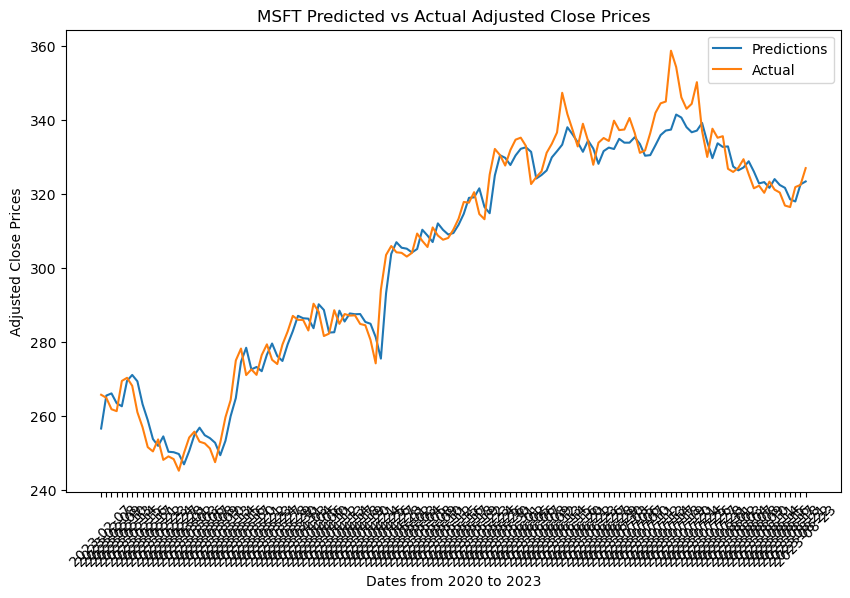

In [136]:
df = pd.read_csv("data/results/pred/MSFT_data.csv") #final predictions of picrosoft.
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Predictions'], label='Predictions')
plt.plot(df['Date'], df['Actual'], label='Actual')
plt.legend()
plt.xticks(rotation=45)
plt.title(f'MSFT Predicted vs Actual Adjusted Close Prices')
plt.xlabel("Dates from 2020 to 2023")
plt.ylabel("Adjusted Close Prices")